# 条件付き拡散モデル

In [1]:
from typing import Dict, Tuple
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np

Text(0.5, 1.0, 'GELU activation function')

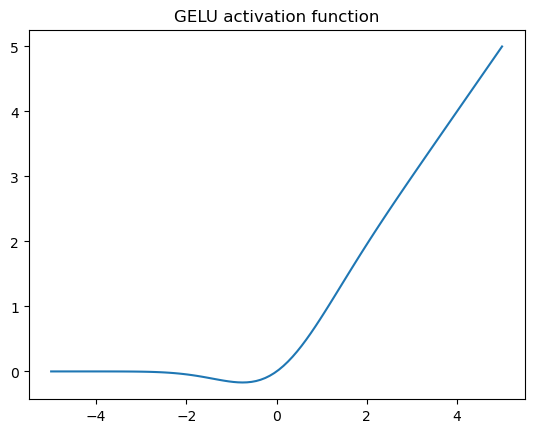

In [2]:
# GELU活性化関数
def gelu(x):
    return x * 0.5 * (1.0 + torch.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * torch.pow(x, 3))))

x = torch.linspace(-5, 5, 100)
y = gelu(x)

plt.plot(x.numpy(), y.numpy(), label="GELU")
plt.title("GELU activation function")

In [51]:
# Residual Convolution Block
class ResConvBlock(nn.Module):
    def __init__(
            self, in_channels: int, out_channels: int, is_res: bool = False
    ) -> None:
        super(ResConvBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.is_res = is_res

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.GELU()
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.GELU()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.is_res:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)

            if self.in_channels == self.out_channels:
                out = x + x2
            else:
                out = x1 + x2

            normalized = out / 1.414
            return normalized
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2


In [ ]:
class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()
        self.model = nn.Sequential(
            ResConvBlock(in_channels, out_channels, is_res=True), nn.MaxPool2d(kernel_size=2)
        )

    def forward(self, x):
        return self.model(x)

class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            ResConvBlock(out_channels, out_channels),
            ResConvBlock(out_channels, out_channels)
        )

    def forward(self, x, skip):
        x = torch.cat((x, skip), dim=1)
        x = self.model(x)
        return x

class EmbedFC(nn.Module):
    def __init__(self, input_dim, embed_dim):
        super(EmbedFC, self).__init__()
        self.input_dim = input_dim
        self.model = nn.Sequential(
            nn.Linear(input_dim, embed_dim),
            nn.GELU(),
            nn.Linear(embed_dim, embed_dim)
        )
    
    def forward(self, x):
        x = x.view(-1, self.input_dim)
        x = self.model(x)
        return x

class ContextUnet(nn.Module):
    def __init__(self, in_channels, num_features=256):
        super(ContextUnet, self).__init__()
        self.in_channels = in_channels
        self.num_features = num_features
        self.num_classes = 10

        self.init_conv = ResConvBlock(in_channels, num_features, is_res=True)
        self.down1 = UnetDown(num_features, num_features)
        self.down2 = UnetDown(num_features, 2 * num_features)

        self.to_vec = nn.Sequential(nn.AvgPool2d(kernel_size=7), nn.GELU())

        self.time_embed1 = EmbedFC(1, 2 * num_features)
        self.time_embed2 = EmbedFC(1, num_features)

        self.context_embed1 = EmbedFC(self.num_classes, 2 * num_features)
        self.context_embed2 = EmbedFC(self.num_classes, num_features)

        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(2 * num_features,
                               2 * num_features,
                               kernel_size=7,
                               stride=7),
            nn.GroupNorm(num_groups=8, num_channels=2 * num_features),
            nn.ReLU()
        )

        self.up1 = UnetUp(4 * num_features, num_features)
        self.up2 = UnetUp(2 * num_features, num_features)

        self.out = nn.Sequential(
            nn.Conv2d(2 * num_features, num_features, kernel_size=3, padding=1, stride=1),
            nn.GroupNorm(num_groups=8, num_channels=num_features),
            nn.ReLU(),
            nn.Conv2d(num_features, self.in_channels, kernel_size=3, padding=1, stride=1),
        )

    def forward(self, x, context, timestep, context_mask):
        # コンテキスト埋め込み
        context = nn.functional.one_hot(context, num_classes=self.num_classes).float()
        context_mask = context_mask.unsqueeze(1).float()
        context_mask = context_mask.repeat(1, self.num_classes)
        context_mask = (-1 * (1 - context_mask)) # 0 -> -1, 1 -> 0
        context = context * context_mask
        context_embed1 = self.context_embed1(context).view(-1, self.num_features * 2, 1, 1)
        context_embed2 = self.context_embed2(context).view(-1, self.num_features, 1, 1)

        # 時間埋め込み
        time_embed1 = self.time_embed1(timestep).view(-1, self.num_features * 2, 1, 1)
        time_embed2 = self.time_embed2(timestep).view(-1, self.num_features, 1, 1)

        # ダウンサンプリング
        x = self.init_conv(x)
        down1 = self.down1(x)
        down2 = self.down2(down1)

        # ボトルネック
        hidden_vec = self.to_vec(down2)

        # hidden_vec = torch.cat((hidden_vec, time_embed1, context_embed1), 1)
        hidden_vec = torch.cat((hidden_vec,), 1)

        # アップサンプリング
        up1 = self.up0(hidden_vec)
        up2 = self.up1(context_embed1 * up1 + time_embed1, down2)
        up3 = self.up2(context_embed2 * up2 + time_embed2, down1)
        out = self.out(torch.cat((up3, x), dim=1))

        return out

$$
\text{a} \quad \alpha_t \\
\text{oneover\_sqrta} \quad 1/\sqrt{\alpha_t} \\
\text{sqrt\_beta\_t} \quad \sqrt{\beta_t} \\
\text{alphabar\_t} \quad \bar{\alpha_t} \\
\text{sqrtab} \quad \sqrt{\bar{\alpha_t}} \\
\text{sqrtmab} \quad \sqrt{1 - \bar{\alpha_t}}  \\
\text{mab\_over\_sqrtmab} \quad (1 - \alpha_t)/\sqrt{1 - \bar{\alpha_t}}
$$

In [44]:
def ddpm_schedules(beta1, beta2, num_steps):
    beta_t = (beta2 - beta1) * torch.arange(0, num_steps + 1, dtype=torch.float32) / num_steps + beta1
    sqrt_beta_t = torch.sqrt(beta_t)
    alpha_t = 1 - beta_t
    log_alpha_t = torch.log(alpha_t)
    alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()
    sqrtab = torch.sqrt(alphabar_t)
    oneover_sqrta = 1 / torch.sqrt(alpha_t)
    sqrtmab = torch.sqrt(1 - alphabar_t)
    mab_over_sqrtmab_inv = (1 - alpha_t) / sqrtmab

    return {
        "alpha_t": alpha_t,  # \alpha_t
        "oneover_sqrta": oneover_sqrta,  # 1/\sqrt{\alpha_t}
        "sqrt_beta_t": sqrt_beta_t,  # \sqrt{\beta_t}
        "alphabar_t": alphabar_t,  # \bar{\alpha_t}
        "sqrtab": sqrtab,  # \sqrt{\bar{\alpha_t}}
        "sqrtmab": sqrtmab,  # \sqrt{1-\bar{\alpha_t}}
        "mab_over_sqrtmab": mab_over_sqrtmab_inv,  # (1-\alpha_t)/\sqrt{1-\bar{\alpha_t}}
    }



In [ ]:
class DDPM(nn.Module):
    def __init__(self, nn_model, betas, num_steps, device, dropout_prob):
        super(DDPM, self).__init__()
        self.nn_model = nn_model.to(device)

        # DDPMサンプリング用のスケジュールを計算して登録
        for k, v in ddpm_schedules(betas[0], betas[1], num_steps).items():
            self.register_buffer(k, v)

        self.num_steps = num_steps
        self.device = device
        self.dropout_prob = dropout_prob
        self.loss_mse = nn.MSELoss()

    def forward(self, x, context):
        steps = torch.randint(1, self.num_steps, (x.shape[0],)).to(self.device)
        noise = torch.randn_like(x)
        x_t = (self.sqrtab[steps, None, None, None] * x +
            self.sqrtmab[steps, None, None, None] * noise)

        # 一定確率でドロップアウトし、ガイダンスの無いモデルを学習
        probs = torch.zeros_like(context) + self.dropout_prob
        context_mask = torch.bernoulli(probs).to(self.device)
        predicted_noise = self.nn_model(x_t, context, steps / self.num_steps, context_mask)
        return self.loss_mse(noise, predicted_noise)

    def sample(self, num_samples, sample_size, device, guidance_weight=0.0):
        # ランダムな初期値
        x_i = torch.randn(num_samples, *sample_size).to(device)

        # 0から9までのコンテキスト
        context_i = torch.arange(0, 10).to(device)
        context_i = context_i.repeat(num_samples // 10)

        # ガイダンスのあるモデルと無いモデルの両方でコンテキストを作成
        context_mask = torch.zeros_like(context_i).to(device)
        context_i = context_i.repeat(2)
        context_mask = context_mask.repeat(2)
        context_mask[num_samples:] = 1. 

        # ログ用
        x_i_store = []

        # 逆拡散過程 t = T, T-1, ..., 0
        for i in range(self.num_steps, 0, -1):
            print(f"サンプリングステップ {i}")
            t_is = torch.tensor([i / self.num_steps]).to(device)
            t_is = t_is.repeat(num_samples, 1, 1, 1)

            x_i = x_i.repeat(2, 1, 1 ,1)
            t_is = t_is.repeat(2, 1, 1, 1)

            z = torch.randn(num_samples, *sample_size).to(device) if i > 1 else 0

            epsilon = self.nn_model(x_i, context_i, t_is, context_mask)
            epsilon1 = epsilon[:num_samples]
            epsilon2 = epsilon[num_samples:]
            epsilon = (1 + guidance_weight) * epsilon1 - guidance_weight * epsilon2
            x_i = x_i[:num_samples]
            x_i = (
                self.oneover_sqrta[i] * (x_i - epsilon * self.mab_over_sqrtmab[i]) +
                self.sqrt_beta_t[i] * z
            )
            if i % 20 == 0 or i == self.num_steps or i < 8:
                x_i_store.append(x_i.detach().cpu().numpy())

        x_i_store = np.array(x_i_store)
        return x_i, x_i_store

In [ ]:
def train_mnist():
    num_epochs = 10
    batch_size = 256
    num_steps = 400
    device = "cuda"
    num_features = 128
    lrate = 1e-4
    save_model = False
    save_dir = "./diffusion_output"
    guidance_weights = [0.0, 0.5, 2.0]
    import os
    os.makedirs(save_dir, exist_ok=True)

    ddpm = DDPM(ContextUnet(1, num_features), (1e-4, 0.02), num_steps, device, 0.1)  
    ddpm.to(device)

    transform = transforms.Compose([transforms.ToTensor()])
    dataset = MNIST("./data", train=True, download=True, transform=transform)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=5)
    optimizer = torch.optim.Adam(ddpm.parameters(), lr=lrate)

    for epoch in range(num_epochs):
        print(f"エポック {epoch}")
        ddpm.train()

        # 線形スケジュールで学習率を減衰
        optimizer.param_groups[0]["lr"] = lrate * (1 - epoch / num_epochs)

        loss_ema = None
        for x, context in tqdm(data_loader):
            optimizer.zero_grad()
            x = x.to(device)
            context = context.to(device)
            loss = ddpm(x, context)
            loss.backward()
            if loss_ema is None:
                loss_ema = loss.item()
            else:
                loss_ema = 0.95 * loss_ema + 0.05 * loss.item()
            optimizer.step()

        ddpm.eval()
        with torch.no_grad():
            num_samples = 4 * 10
            for index, weight in enumerate(guidance_weights):
                sample_size = (1, 28, 28)
                x_gen, x_gen_store = ddpm.sample(num_samples, sample_size, device, weight)

                x_real = torch.Tensor(x_gen.shape).to(device)
                for k in range(10):
                    for j in range(int(num_samples / 10)):
                        try:
                            idx = torch.squeeze((context == k).nonzero())[j]
                        except:
                            idx = 0

                        x_real[k + (j * 10)] = x[index]

                x_all = torch.cat([x_gen, x_real])
                grid = make_grid(x_all * -1 + 1, nrow = 10)
                save_image(grid, f"{save_dir}/epoch_{epoch}_weight_{weight}.png")
                print(f"画像保存: {save_dir}/epoch_{epoch}_weight_{weight}.png")

        if save_model and epoch == int(num_epochs-1):
            torch.save(ddpm.state_dict(), save_dir + f"model_{epoch}.pth")
            print('saved model at ' + save_dir + f"model_{epoch}.pth")

train_mnist()

            


エポック 0


100%|██████████| 235/235 [00:51<00:00,  4.55it/s]


サンプリングステップ 400
サンプリングステップ 399
サンプリングステップ 398
サンプリングステップ 397
サンプリングステップ 396
サンプリングステップ 395
サンプリングステップ 394
サンプリングステップ 393
サンプリングステップ 392
サンプリングステップ 391
サンプリングステップ 390
サンプリングステップ 389
サンプリングステップ 388
サンプリングステップ 387
サンプリングステップ 386
サンプリングステップ 385
サンプリングステップ 384
サンプリングステップ 383
サンプリングステップ 382
サンプリングステップ 381
サンプリングステップ 380
サンプリングステップ 379
サンプリングステップ 378
サンプリングステップ 377
サンプリングステップ 376
サンプリングステップ 375
サンプリングステップ 374
サンプリングステップ 373
サンプリングステップ 372
サンプリングステップ 371
サンプリングステップ 370
サンプリングステップ 369
サンプリングステップ 368
サンプリングステップ 367
サンプリングステップ 366
サンプリングステップ 365
サンプリングステップ 364
サンプリングステップ 363
サンプリングステップ 362
サンプリングステップ 361
サンプリングステップ 360
サンプリングステップ 359
サンプリングステップ 358
サンプリングステップ 357
サンプリングステップ 356
サンプリングステップ 355
サンプリングステップ 354
サンプリングステップ 353
サンプリングステップ 352
サンプリングステップ 351
サンプリングステップ 350
サンプリングステップ 349
サンプリングステップ 348
サンプリングステップ 347
サンプリングステップ 346
サンプリングステップ 345
サンプリングステップ 344
サンプリングステップ 343
サンプリングステップ 342
サンプリングステップ 341
サンプリングステップ 340
サンプリングステップ 339
サンプリングステップ 338
サンプリングステップ 337
サンプリングステップ 336
サンプリングステップ 335
サンプリングステップ

100%|██████████| 235/235 [00:49<00:00,  4.78it/s]


サンプリングステップ 400
サンプリングステップ 399
サンプリングステップ 398
サンプリングステップ 397
サンプリングステップ 396
サンプリングステップ 395
サンプリングステップ 394
サンプリングステップ 393
サンプリングステップ 392
サンプリングステップ 391
サンプリングステップ 390
サンプリングステップ 389
サンプリングステップ 388
サンプリングステップ 387
サンプリングステップ 386
サンプリングステップ 385
サンプリングステップ 384
サンプリングステップ 383
サンプリングステップ 382
サンプリングステップ 381
サンプリングステップ 380
サンプリングステップ 379
サンプリングステップ 378
サンプリングステップ 377
サンプリングステップ 376
サンプリングステップ 375
サンプリングステップ 374
サンプリングステップ 373
サンプリングステップ 372
サンプリングステップ 371
サンプリングステップ 370
サンプリングステップ 369
サンプリングステップ 368
サンプリングステップ 367
サンプリングステップ 366
サンプリングステップ 365
サンプリングステップ 364
サンプリングステップ 363
サンプリングステップ 362
サンプリングステップ 361
サンプリングステップ 360
サンプリングステップ 359
サンプリングステップ 358
サンプリングステップ 357
サンプリングステップ 356
サンプリングステップ 355
サンプリングステップ 354
サンプリングステップ 353
サンプリングステップ 352
サンプリングステップ 351
サンプリングステップ 350
サンプリングステップ 349
サンプリングステップ 348
サンプリングステップ 347
サンプリングステップ 346
サンプリングステップ 345
サンプリングステップ 344
サンプリングステップ 343
サンプリングステップ 342
サンプリングステップ 341
サンプリングステップ 340
サンプリングステップ 339
サンプリングステップ 338
サンプリングステップ 337
サンプリングステップ 336
サンプリングステップ 335
サンプリングステップ

100%|██████████| 235/235 [00:49<00:00,  4.71it/s]


サンプリングステップ 400
サンプリングステップ 399
サンプリングステップ 398
サンプリングステップ 397
サンプリングステップ 396
サンプリングステップ 395
サンプリングステップ 394
サンプリングステップ 393
サンプリングステップ 392
サンプリングステップ 391
サンプリングステップ 390
サンプリングステップ 389
サンプリングステップ 388
サンプリングステップ 387
サンプリングステップ 386
サンプリングステップ 385
サンプリングステップ 384
サンプリングステップ 383
サンプリングステップ 382
サンプリングステップ 381
サンプリングステップ 380
サンプリングステップ 379
サンプリングステップ 378
サンプリングステップ 377
サンプリングステップ 376
サンプリングステップ 375
サンプリングステップ 374
サンプリングステップ 373
サンプリングステップ 372
サンプリングステップ 371
サンプリングステップ 370
サンプリングステップ 369
サンプリングステップ 368
サンプリングステップ 367
サンプリングステップ 366
サンプリングステップ 365
サンプリングステップ 364
サンプリングステップ 363
サンプリングステップ 362
サンプリングステップ 361
サンプリングステップ 360
サンプリングステップ 359
サンプリングステップ 358
サンプリングステップ 357
サンプリングステップ 356
サンプリングステップ 355
サンプリングステップ 354
サンプリングステップ 353
サンプリングステップ 352
サンプリングステップ 351
サンプリングステップ 350
サンプリングステップ 349
サンプリングステップ 348
サンプリングステップ 347
サンプリングステップ 346
サンプリングステップ 345
サンプリングステップ 344
サンプリングステップ 343
サンプリングステップ 342
サンプリングステップ 341
サンプリングステップ 340
サンプリングステップ 339
サンプリングステップ 338
サンプリングステップ 337
サンプリングステップ 336
サンプリングステップ 335
サンプリングステップ

100%|██████████| 235/235 [00:48<00:00,  4.81it/s]


サンプリングステップ 400
サンプリングステップ 399
サンプリングステップ 398
サンプリングステップ 397
サンプリングステップ 396
サンプリングステップ 395
サンプリングステップ 394
サンプリングステップ 393
サンプリングステップ 392
サンプリングステップ 391
サンプリングステップ 390
サンプリングステップ 389
サンプリングステップ 388
サンプリングステップ 387
サンプリングステップ 386
サンプリングステップ 385
サンプリングステップ 384
サンプリングステップ 383
サンプリングステップ 382
サンプリングステップ 381
サンプリングステップ 380
サンプリングステップ 379
サンプリングステップ 378
サンプリングステップ 377
サンプリングステップ 376
サンプリングステップ 375
サンプリングステップ 374
サンプリングステップ 373
サンプリングステップ 372
サンプリングステップ 371
サンプリングステップ 370
サンプリングステップ 369
サンプリングステップ 368
サンプリングステップ 367
サンプリングステップ 366
サンプリングステップ 365
サンプリングステップ 364
サンプリングステップ 363
サンプリングステップ 362
サンプリングステップ 361
サンプリングステップ 360
サンプリングステップ 359
サンプリングステップ 358
サンプリングステップ 357
サンプリングステップ 356
サンプリングステップ 355
サンプリングステップ 354
サンプリングステップ 353
サンプリングステップ 352
サンプリングステップ 351
サンプリングステップ 350
サンプリングステップ 349
サンプリングステップ 348
サンプリングステップ 347
サンプリングステップ 346
サンプリングステップ 345
サンプリングステップ 344
サンプリングステップ 343
サンプリングステップ 342
サンプリングステップ 341
サンプリングステップ 340
サンプリングステップ 339
サンプリングステップ 338
サンプリングステップ 337
サンプリングステップ 336
サンプリングステップ 335
サンプリングステップ

100%|██████████| 235/235 [00:50<00:00,  4.63it/s]


サンプリングステップ 400
サンプリングステップ 399
サンプリングステップ 398
サンプリングステップ 397
サンプリングステップ 396
サンプリングステップ 395
サンプリングステップ 394
サンプリングステップ 393
サンプリングステップ 392
サンプリングステップ 391
サンプリングステップ 390
サンプリングステップ 389
サンプリングステップ 388
サンプリングステップ 387
サンプリングステップ 386
サンプリングステップ 385
サンプリングステップ 384
サンプリングステップ 383
サンプリングステップ 382
サンプリングステップ 381
サンプリングステップ 380
サンプリングステップ 379
サンプリングステップ 378
サンプリングステップ 377
サンプリングステップ 376
サンプリングステップ 375
サンプリングステップ 374
サンプリングステップ 373
サンプリングステップ 372
サンプリングステップ 371
サンプリングステップ 370
サンプリングステップ 369
サンプリングステップ 368
サンプリングステップ 367
サンプリングステップ 366
サンプリングステップ 365
サンプリングステップ 364
サンプリングステップ 363
サンプリングステップ 362
サンプリングステップ 361
サンプリングステップ 360
サンプリングステップ 359
サンプリングステップ 358
サンプリングステップ 357
サンプリングステップ 356
サンプリングステップ 355
サンプリングステップ 354
サンプリングステップ 353
サンプリングステップ 352
サンプリングステップ 351
サンプリングステップ 350
サンプリングステップ 349
サンプリングステップ 348
サンプリングステップ 347
サンプリングステップ 346
サンプリングステップ 345
サンプリングステップ 344
サンプリングステップ 343
サンプリングステップ 342
サンプリングステップ 341
サンプリングステップ 340
サンプリングステップ 339
サンプリングステップ 338
サンプリングステップ 337
サンプリングステップ 336
サンプリングステップ 335
サンプリングステップ

100%|██████████| 235/235 [00:50<00:00,  4.66it/s]


サンプリングステップ 400
サンプリングステップ 399
サンプリングステップ 398
サンプリングステップ 397
サンプリングステップ 396
サンプリングステップ 395
サンプリングステップ 394
サンプリングステップ 393
サンプリングステップ 392
サンプリングステップ 391
サンプリングステップ 390
サンプリングステップ 389
サンプリングステップ 388
サンプリングステップ 387
サンプリングステップ 386
サンプリングステップ 385
サンプリングステップ 384
サンプリングステップ 383
サンプリングステップ 382
サンプリングステップ 381
サンプリングステップ 380
サンプリングステップ 379
サンプリングステップ 378
サンプリングステップ 377
サンプリングステップ 376
サンプリングステップ 375
サンプリングステップ 374
サンプリングステップ 373
サンプリングステップ 372
サンプリングステップ 371
サンプリングステップ 370
サンプリングステップ 369
サンプリングステップ 368
サンプリングステップ 367
サンプリングステップ 366
サンプリングステップ 365
サンプリングステップ 364
サンプリングステップ 363
サンプリングステップ 362
サンプリングステップ 361
サンプリングステップ 360
サンプリングステップ 359
サンプリングステップ 358
サンプリングステップ 357
サンプリングステップ 356
サンプリングステップ 355
サンプリングステップ 354
サンプリングステップ 353
サンプリングステップ 352
サンプリングステップ 351
サンプリングステップ 350
サンプリングステップ 349
サンプリングステップ 348
サンプリングステップ 347
サンプリングステップ 346
サンプリングステップ 345
サンプリングステップ 344
サンプリングステップ 343
サンプリングステップ 342
サンプリングステップ 341
サンプリングステップ 340
サンプリングステップ 339
サンプリングステップ 338
サンプリングステップ 337
サンプリングステップ 336
サンプリングステップ 335
サンプリングステップ

100%|██████████| 235/235 [00:49<00:00,  4.73it/s]


サンプリングステップ 400
サンプリングステップ 399
サンプリングステップ 398
サンプリングステップ 397
サンプリングステップ 396
サンプリングステップ 395
サンプリングステップ 394
サンプリングステップ 393
サンプリングステップ 392
サンプリングステップ 391
サンプリングステップ 390
サンプリングステップ 389
サンプリングステップ 388
サンプリングステップ 387
サンプリングステップ 386
サンプリングステップ 385
サンプリングステップ 384
サンプリングステップ 383
サンプリングステップ 382
サンプリングステップ 381
サンプリングステップ 380
サンプリングステップ 379
サンプリングステップ 378
サンプリングステップ 377
サンプリングステップ 376
サンプリングステップ 375
サンプリングステップ 374
サンプリングステップ 373
サンプリングステップ 372
サンプリングステップ 371
サンプリングステップ 370
サンプリングステップ 369
サンプリングステップ 368
サンプリングステップ 367
サンプリングステップ 366
サンプリングステップ 365
サンプリングステップ 364
サンプリングステップ 363
サンプリングステップ 362
サンプリングステップ 361
サンプリングステップ 360
サンプリングステップ 359
サンプリングステップ 358
サンプリングステップ 357
サンプリングステップ 356
サンプリングステップ 355
サンプリングステップ 354
サンプリングステップ 353
サンプリングステップ 352
サンプリングステップ 351
サンプリングステップ 350
サンプリングステップ 349
サンプリングステップ 348
サンプリングステップ 347
サンプリングステップ 346
サンプリングステップ 345
サンプリングステップ 344
サンプリングステップ 343
サンプリングステップ 342
サンプリングステップ 341
サンプリングステップ 340
サンプリングステップ 339
サンプリングステップ 338
サンプリングステップ 337
サンプリングステップ 336
サンプリングステップ 335
サンプリングステップ

100%|██████████| 235/235 [00:46<00:00,  5.11it/s]


サンプリングステップ 400
サンプリングステップ 399
サンプリングステップ 398
サンプリングステップ 397
サンプリングステップ 396
サンプリングステップ 395
サンプリングステップ 394
サンプリングステップ 393
サンプリングステップ 392
サンプリングステップ 391
サンプリングステップ 390
サンプリングステップ 389
サンプリングステップ 388
サンプリングステップ 387
サンプリングステップ 386
サンプリングステップ 385
サンプリングステップ 384
サンプリングステップ 383
サンプリングステップ 382
サンプリングステップ 381
サンプリングステップ 380
サンプリングステップ 379
サンプリングステップ 378
サンプリングステップ 377
サンプリングステップ 376
サンプリングステップ 375
サンプリングステップ 374
サンプリングステップ 373
サンプリングステップ 372
サンプリングステップ 371
サンプリングステップ 370
サンプリングステップ 369
サンプリングステップ 368
サンプリングステップ 367
サンプリングステップ 366
サンプリングステップ 365
サンプリングステップ 364
サンプリングステップ 363
サンプリングステップ 362
サンプリングステップ 361
サンプリングステップ 360
サンプリングステップ 359
サンプリングステップ 358
サンプリングステップ 357
サンプリングステップ 356
サンプリングステップ 355
サンプリングステップ 354
サンプリングステップ 353
サンプリングステップ 352
サンプリングステップ 351
サンプリングステップ 350
サンプリングステップ 349
サンプリングステップ 348
サンプリングステップ 347
サンプリングステップ 346
サンプリングステップ 345
サンプリングステップ 344
サンプリングステップ 343
サンプリングステップ 342
サンプリングステップ 341
サンプリングステップ 340
サンプリングステップ 339
サンプリングステップ 338
サンプリングステップ 337
サンプリングステップ 336
サンプリングステップ 335
サンプリングステップ

100%|██████████| 235/235 [00:46<00:00,  5.11it/s]


サンプリングステップ 400
サンプリングステップ 399
サンプリングステップ 398
サンプリングステップ 397
サンプリングステップ 396
サンプリングステップ 395
サンプリングステップ 394
サンプリングステップ 393
サンプリングステップ 392
サンプリングステップ 391
サンプリングステップ 390
サンプリングステップ 389
サンプリングステップ 388
サンプリングステップ 387
サンプリングステップ 386
サンプリングステップ 385
サンプリングステップ 384
サンプリングステップ 383
サンプリングステップ 382
サンプリングステップ 381
サンプリングステップ 380
サンプリングステップ 379
サンプリングステップ 378
サンプリングステップ 377
サンプリングステップ 376
サンプリングステップ 375
サンプリングステップ 374
サンプリングステップ 373
サンプリングステップ 372
サンプリングステップ 371
サンプリングステップ 370
サンプリングステップ 369
サンプリングステップ 368
サンプリングステップ 367
サンプリングステップ 366
サンプリングステップ 365
サンプリングステップ 364
サンプリングステップ 363
サンプリングステップ 362
サンプリングステップ 361
サンプリングステップ 360
サンプリングステップ 359
サンプリングステップ 358
サンプリングステップ 357
サンプリングステップ 356
サンプリングステップ 355
サンプリングステップ 354
サンプリングステップ 353
サンプリングステップ 352
サンプリングステップ 351
サンプリングステップ 350
サンプリングステップ 349
サンプリングステップ 348
サンプリングステップ 347
サンプリングステップ 346
サンプリングステップ 345
サンプリングステップ 344
サンプリングステップ 343
サンプリングステップ 342
サンプリングステップ 341
サンプリングステップ 340
サンプリングステップ 339
サンプリングステップ 338
サンプリングステップ 337
サンプリングステップ 336
サンプリングステップ 335
サンプリングステップ

100%|██████████| 235/235 [00:46<00:00,  5.11it/s]


サンプリングステップ 400
サンプリングステップ 399
サンプリングステップ 398
サンプリングステップ 397
サンプリングステップ 396
サンプリングステップ 395
サンプリングステップ 394
サンプリングステップ 393
サンプリングステップ 392
サンプリングステップ 391
サンプリングステップ 390
サンプリングステップ 389
サンプリングステップ 388
サンプリングステップ 387
サンプリングステップ 386
サンプリングステップ 385
サンプリングステップ 384
サンプリングステップ 383
サンプリングステップ 382
サンプリングステップ 381
サンプリングステップ 380
サンプリングステップ 379
サンプリングステップ 378
サンプリングステップ 377
サンプリングステップ 376
サンプリングステップ 375
サンプリングステップ 374
サンプリングステップ 373
サンプリングステップ 372
サンプリングステップ 371
サンプリングステップ 370
サンプリングステップ 369
サンプリングステップ 368
サンプリングステップ 367
サンプリングステップ 366
サンプリングステップ 365
サンプリングステップ 364
サンプリングステップ 363
サンプリングステップ 362
サンプリングステップ 361
サンプリングステップ 360
サンプリングステップ 359
サンプリングステップ 358
サンプリングステップ 357
サンプリングステップ 356
サンプリングステップ 355
サンプリングステップ 354
サンプリングステップ 353
サンプリングステップ 352
サンプリングステップ 351
サンプリングステップ 350
サンプリングステップ 349
サンプリングステップ 348
サンプリングステップ 347
サンプリングステップ 346
サンプリングステップ 345
サンプリングステップ 344
サンプリングステップ 343
サンプリングステップ 342
サンプリングステップ 341
サンプリングステップ 340
サンプリングステップ 339
サンプリングステップ 338
サンプリングステップ 337
サンプリングステップ 336
サンプリングステップ 335
サンプリングステップ

100%|██████████| 235/235 [00:47<00:00,  4.95it/s]


サンプリングステップ 400
サンプリングステップ 399
サンプリングステップ 398
サンプリングステップ 397
サンプリングステップ 396
サンプリングステップ 395
サンプリングステップ 394
サンプリングステップ 393
サンプリングステップ 392
サンプリングステップ 391
サンプリングステップ 390
サンプリングステップ 389
サンプリングステップ 388
サンプリングステップ 387
サンプリングステップ 386
サンプリングステップ 385
サンプリングステップ 384
サンプリングステップ 383
サンプリングステップ 382
サンプリングステップ 381
サンプリングステップ 380
サンプリングステップ 379
サンプリングステップ 378
サンプリングステップ 377
サンプリングステップ 376
サンプリングステップ 375
サンプリングステップ 374
サンプリングステップ 373
サンプリングステップ 372
サンプリングステップ 371
サンプリングステップ 370
サンプリングステップ 369
サンプリングステップ 368
サンプリングステップ 367
サンプリングステップ 366
サンプリングステップ 365
サンプリングステップ 364
サンプリングステップ 363
サンプリングステップ 362
サンプリングステップ 361
サンプリングステップ 360
サンプリングステップ 359
サンプリングステップ 358
サンプリングステップ 357
サンプリングステップ 356
サンプリングステップ 355
サンプリングステップ 354
サンプリングステップ 353
サンプリングステップ 352
サンプリングステップ 351
サンプリングステップ 350
サンプリングステップ 349
サンプリングステップ 348
サンプリングステップ 347
サンプリングステップ 346
サンプリングステップ 345
サンプリングステップ 344
サンプリングステップ 343
サンプリングステップ 342
サンプリングステップ 341
サンプリングステップ 340
サンプリングステップ 339
サンプリングステップ 338
サンプリングステップ 337
サンプリングステップ 336
サンプリングステップ 335
サンプリングステップ

KeyboardInterrupt: 